<a href="https://colab.research.google.com/github/Sebin-Yoon/Skull-Stripping-CNN/blob/main/2D_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
from numpy import expand_dims
import cv2
import nibabel as nib 
import matplotlib.pyplot as plt
import glob
import pandas as pd
from pathlib import Path
from google.colab import drive
import tensorflow as tf
from tensorflow import keras
from keras import layers
import keras.backend as K
from keras.models import Model
from keras.layers import Input, concatenate, Conv2D, MaxPooling2D, Activation, UpSampling2D, BatchNormalization, Dropout
from tensorflow.keras.layers.experimental import preprocessing 
from tensorflow.keras.optimizers import *
from sklearn.model_selection import train_test_split
from IPython.display import clear_output


In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


Import the Data from drive

In [ ]:
os.listdir(Path('/content/drive/MyDrive/NFBS_Dataset'))

Folder name will be patient name here
so make a dataframe to hold all the names

In [ ]:
patient_id_df = pd.DataFrame(os.listdir(Path('/content/drive/MyDrive/NFBS_Dataset')),columns=['id'])

In [ ]:
patient_id_df.head

<bound method NDFrame.head of             id
0    A00034854
1    A00028185
2    A00037511
3    A00037112
4    A00035840
..         ...
120  A00064081
121  A00063326
122  A00063103
123  A00063589
124  A00063368

[125 rows x 1 columns]>

Set the data path

In [ ]:
DATA_PATH = Path('/content/drive/MyDrive/NFBS_Dataset')

See how many patients we have

In [ ]:
patients = os.listdir(Path('/content/drive/MyDrive/NFBS_Dataset'))
len(patients)

125

#Time to set up the Training, testing, and validation set.

In [ ]:
TRAIN_PATH = Path('/content/drive/MyDrive/NFBS_Dataset')

In [ ]:
train_dir = [f.path for f in os.scandir(TRAIN_PATH) if f.is_dir()]

def list_to_ids(dir:str):
    """
    Will convert the dir paths to ids by parsing the paths.
    dir: string, image dir paths in BRATS
    """
    x = []
    for i in range(0,len(dir)):
        x.append(dir[i].split('/')[-1])
    return x

split up the data for training, validation, and testing

In [ ]:
# Now let's use the defined function
# Set a random state so the splits are the same
ids = list_to_ids(train_dir) 

# Split dataset to create training ids, validation ids and test ids
# Here we have selected the size of test set as 20% which is a common practice.
train_ids, test_ids = train_test_split(ids,test_size=0.2,random_state=42) 

# Create validation ids by further splitting the train ids, we again use 20% as size of valisation set. 
# Validation set is also referred to as tuning set. 

train_ids, val_ids = train_test_split(train_ids,test_size=0.2,random_state=42) 

In [ ]:
print(f'There are {len(train_ids)} patient ids in training set')
print(f'There are {len(val_ids)} patient ids in validation set')
print(f'There are {len(test_ids)} patient ids in test set')

There are 80 patient ids in training set
There are 20 patient ids in validation set
There are 25 patient ids in test set


See how to access the data and pull the nifti images

##Take a look at the data

In [ ]:
# Test for file format #

# patient_id = 'A00034854'
# image = ''
# test = nib.load(Path(TRAIN_PATH,f'{patient_id}',f'sub-{patient_id}_ses-NFB3_T1w{image}.nii.gz'))
# plt.imshow(test._dataobj[:,test.shape[-1]//2, :], cmap='gray') 


In [ ]:
def read_patient_niftis(patient_id: str, data_path = TRAIN_PATH, niftis_to_load = ['brain','brainmask','']):
    patient_image_dict = {}
    for image in niftis_to_load:
        if image == '':
          patient_image_dict[image] = nib.load(Path(data_path,f'{patient_id}',f'sub-{patient_id}_ses-NFB3_T1w{image}.nii.gz'))
        else:
          patient_image_dict[image] = nib.load(Path(data_path,f'{patient_id}',f'sub-{patient_id}_ses-NFB3_T1w_{image}.nii.gz'))
    return (patient_image_dict)

In [ ]:
# Testing to see if all the nifti are the same size
# def count_shape():
#   shape = [];
#   for x in patients:
#     all_patients = read_patient_niftis(patient_id = x, data_path = TRAIN_PATH, niftis_to_load = ['brainmask'])
#     for i, (key, value) in enumerate(all_patients.items()):
#       shape.append(value.shape)
#   return (shape)

In [ ]:
pt_img_dict = read_patient_niftis(train_ids[12])

(256, 192)
(256, 192)
(256, 192)


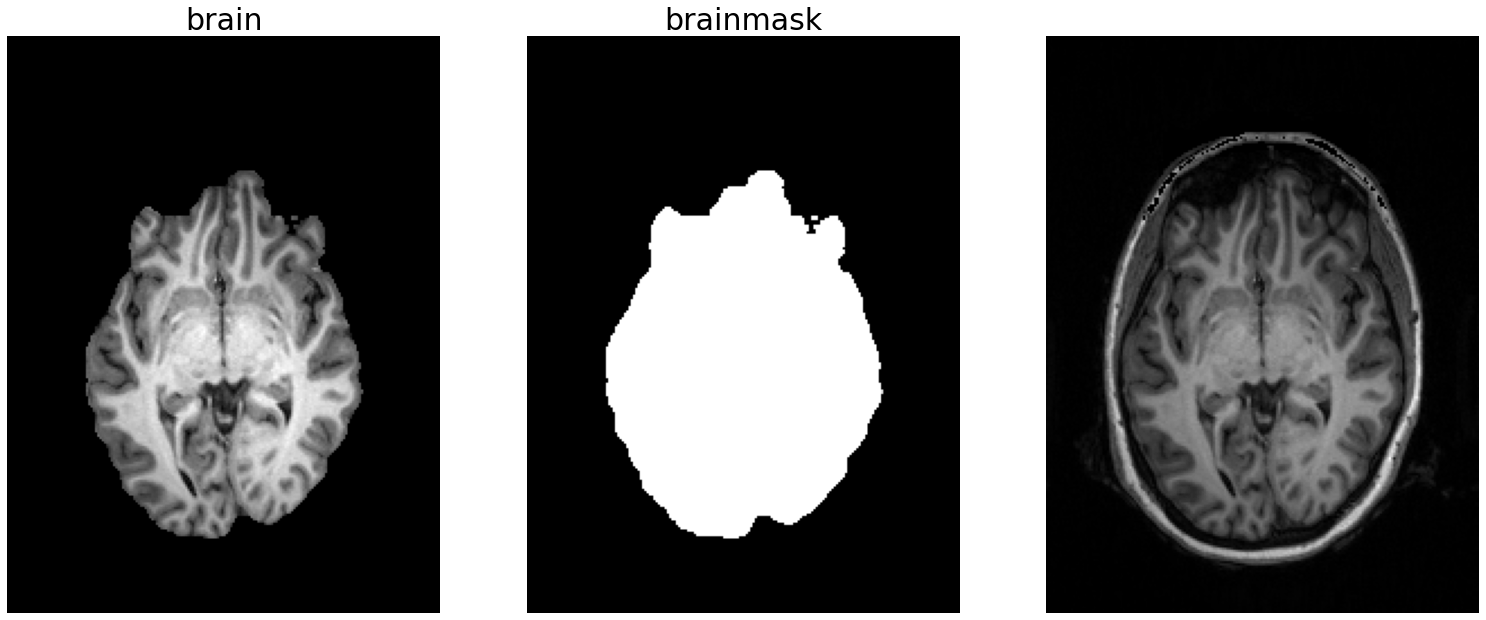

In [ ]:

plt.figure(figsize=(45,30)) # specifying the overall grid size
for i, (key, value) in enumerate(pt_img_dict.items()):
    plt.subplot(1, 5, i+1)
    img = value._dataobj[:, value.shape[-1]//2, :]
    print(img.shape)
    plt.imshow(img, cmap='gray') # Looks halfway through the volume. 
    plt.axis('off')
    #plt.title("{key1}, object shape: {shape}".format(key1=key,shape=value.shape), fontsize=30)
    plt.title(key, fontsize=30)
plt.show()

In [ ]:
for i, (key, value) in enumerate(pt_img_dict.items()):
    print(value.shape[2]) # Looks halfway through the volume. 
    #plt.title("{key1}, object shape: {shape}".format(key1=key,shape=value.shape), fontsize=30)


192
192
192


#Model set up test

In [ ]:
# Dice
def dice_coef(y_true, y_pred):
    """
    Dice coefficient for semantic segmentation.
    
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    
    y_true: The ground truth tensor.
    y_pred: The predicted tensor
    smooth: Smoothing factor. Default is 100.    
    """
    
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

# Jaccard/IoU
def jacard_coef(y_true, y_pred):
    """
    Jaccard coefficient for semantic segmentation. Also known as the IOU loss.
    
    Jaccard = (|X & Y|)/ (|X|+ |Y| - |X & Y|)
            = sum(|A*B|)/(sum(|A|)+sum(|B|)-sum(|A*B|))
    
    y_true: The ground truth tensor.
    y_pred: The predicted tensor
    smooth: Smoothing factor. Default is 100.    
    """
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)

In [ ]:
# The 2 loss functions we will look at are Dice and Jaccard loss

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def jacard_coef_loss(y_true, y_pred):
    return -jacard_coef(y_true, y_pred)




#2D Unet Model From Lecture

In [ ]:
org_img = pt_img_dict[''].get_fdata()
seg_img = pt_img_dict['brainmask'].get_fdata()

In [ ]:
# For this semantic segmentation task, we will use T2 images.
# And we will focus on binary or whole tumor (WT) segmentation. In order to do so we will assign the same pixel intensity (1) to the 3 tumor sub regions (1, 2, 4)


def normalize(input_image = org_img,
              input_mask = seg_img,
              percentile = 0.001,
              eps = 0.0000001):
    """
    Will read the input image and normalize the image between 0 and 1.
    Will read the input mask and assign pixel value 1 to all tumor subregions (1, 2, 4).
    input_image: default is t2_img, the image to be segmented.
    input_mask: default is seg_img, the ground truth or label.
    """
    img_array = np.ndarray.flatten(input_image)
    min_img, max_img = np.quantile(img_array, percentile), np.quantile(img_array, 1-percentile)
    img_normalized = ((input_image-min_img)/(max_img-min_img+eps)*255).astype(np.uint8)
    img_normalized = tf.cast(img_normalized, tf.float32) / 255
    
    mask_normalized = np.where(input_mask >=1, 1, 0)
    return img_normalized, mask_normalized


In [ ]:
# Define the UNet model
def get_unet(input_shape=(None, None, 1),
                  num_classes=1):
    inputs = Input(shape=input_shape)
    down1 = Conv2D(64, (3, 3), activation = 'relu', padding='same')(inputs)
    down1 = BatchNormalization()(down1)
    down1 = Conv2D(64, (3, 3), activation = 'relu', padding='same')(down1)
    down1 = BatchNormalization()(down1)
    down1_pool = MaxPooling2D((2, 2), strides=(2, 2))(down1)
    # 64

    down2 = Conv2D(128, (3, 3), activation = 'relu', padding='same')(down1_pool)
    down2 = BatchNormalization()(down2)
    down2 = Conv2D(128, (3, 3), activation = 'relu', padding='same')(down2)
    down2 = BatchNormalization()(down2)
    down2_pool = MaxPooling2D((2, 2), strides=(2, 2))(down2)
    # 32

    down3 = Conv2D(256, (3, 3), activation = 'relu', padding='same')(down2_pool)
    down3 = BatchNormalization()(down3)
    down3 = Conv2D(256, (3, 3), activation = 'relu', padding='same')(down3)
    down3 = BatchNormalization()(down3)
    down3_pool = MaxPooling2D((2, 2), strides=(2, 2))(down3)
    # 16

    down4 = Conv2D(512, (3, 3), activation = 'relu', padding='same')(down3_pool)
    down4 = BatchNormalization()(down4)
    down4 = Conv2D(512, (3, 3), activation = 'relu', padding='same')(down4)
    down4 = BatchNormalization()(down4)
    down4_pool = MaxPooling2D((2, 2), strides=(2, 2))(down4)
    # 8

    center = Conv2D(1024, (3, 3), activation = 'relu', padding='same')(down4_pool)
    center = BatchNormalization()(center)
    center = Conv2D(1024, (3, 3), activation = 'relu', padding='same')(center)
    center = BatchNormalization()(center)
    # center

    up4 = UpSampling2D((2, 2))(center)
    up4 = concatenate([down4, up4], axis=3)
    up4 = Conv2D(512, (3, 3), activation = 'relu', padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Conv2D(512, (3, 3), activation = 'relu', padding='same')(up4)
    up4 = BatchNormalization()(up4)
    up4 = Conv2D(512, (3, 3), activation = 'relu', padding='same')(up4)
    up4 = BatchNormalization()(up4)
    # 16

    up3 = UpSampling2D((2, 2))(up4)
    up3 = concatenate([down3, up3], axis=3)
    up3 = Conv2D(256, (3, 3), activation = 'relu', padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Conv2D(256, (3, 3), activation = 'relu', padding='same')(up3)
    up3 = BatchNormalization()(up3)
    up3 = Conv2D(256, (3, 3), activation = 'relu', padding='same')(up3)
    up3 = BatchNormalization()(up3)
    # 32

    up2 = UpSampling2D((2, 2))(up3)
    up2 = concatenate([down2, up2], axis=3)
    up2 = Conv2D(128, (3, 3), activation = 'relu', padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Conv2D(128, (3, 3), activation = 'relu', padding='same')(up2)
    up2 = BatchNormalization()(up2)
    up2 = Conv2D(128, (3, 3), activation = 'relu', padding='same')(up2)
    up2 = BatchNormalization()(up2)
    # 64

    up1 = UpSampling2D((2, 2))(up2)
    up1 = concatenate([down1, up1], axis=3)
    up1 = Conv2D(64, (3, 3), activation = 'relu', padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Conv2D(64, (3, 3), activation = 'relu', padding='same')(up1)
    up1 = BatchNormalization()(up1)
    up1 = Conv2D(64, (3, 3), activation = 'relu', padding='same')(up1)
    up1 = BatchNormalization()(up1)
    # 128

    classify = Conv2D(1, (1, 1), activation='sigmoid')(up1)

    model = Model(inputs=inputs, outputs=classify)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss=dice_coef_loss, metrics=[dice_coef])
    return model

model = get_unet()

##2D Unet data setup

This the one that works

In [ ]:
# # Let's define a function to create numpy arrays of training, validation and test images.

# # For the sake of simplicity, we will use only the middle slice of each volume for this experiment.

# X = []
# Y = []

# def create_numpy_array(patient_ids:str,
#                        DATA_PATH):
#     X = []
#     Y = []
    
#     for i in range(len(patient_ids)):
#         pt_img_dict = read_patient_niftis(patient_ids[i],
#                                           niftis_to_load = ['', 'brainmask'], 
#                                           data_path = DATA_PATH)
        
#         images = []
#         for q in range(31,183):
#           for j, (key, value) in enumerate(pt_img_dict.items()):
#             if j == 0:
#               X.append(expand_dims(value._dataobj[:,q,:], axis=2))
#               #X.append(expand_dims(value._dataobj[:,q,:], axis=2))
#             elif j == 1:
#               Y.append(expand_dims(value._dataobj[:,q,:], axis=2))
#               #Y.append(expand_dims(value._dataobj[:,q,:], axis=2))

#     return np.asarray(X), np.asarray(Y)



This is a test

In [ ]:
# Let's define a function to create numpy arrays of training, validation and test images.

# For the sake of simplicity, we will use only the middle slice of each volume for this experiment.

X = []
Y = []

def create_numpy_array(patient_ids:str,
                       DATA_PATH):
    X = []
    Y = []
    
    for i in range(len(patient_ids)):
        pt_img_dict = read_patient_niftis(patient_ids[i],
                                          niftis_to_load = ['', 'brainmask'], 
                                          data_path = DATA_PATH)
        
        images = []
        for j, (key, value) in enumerate(pt_img_dict.items()):
          for q in range(31,183):
            if j == 0:
              X.append(expand_dims(value._dataobj[:,q,:], axis=2))
              #X.append(expand_dims(value._dataobj[:,q,:], axis=2))
            elif j == 1:
              Y.append(expand_dims(value._dataobj[:,q,:], axis=2))
              #Y.append(expand_dims(value._dataobj[:,q,:], axis=2))

    return np.asarray(X), np.asarray(Y)



In [ ]:
test_id = []
test_id.append(train_ids[0]);  
print(test_id)
test_id_skull, test_id_mask = create_numpy_array(test_id, DATA_PATH)

['A00055373']


In [ ]:
test_id_skull.shape

(256, 256, 192, 1)

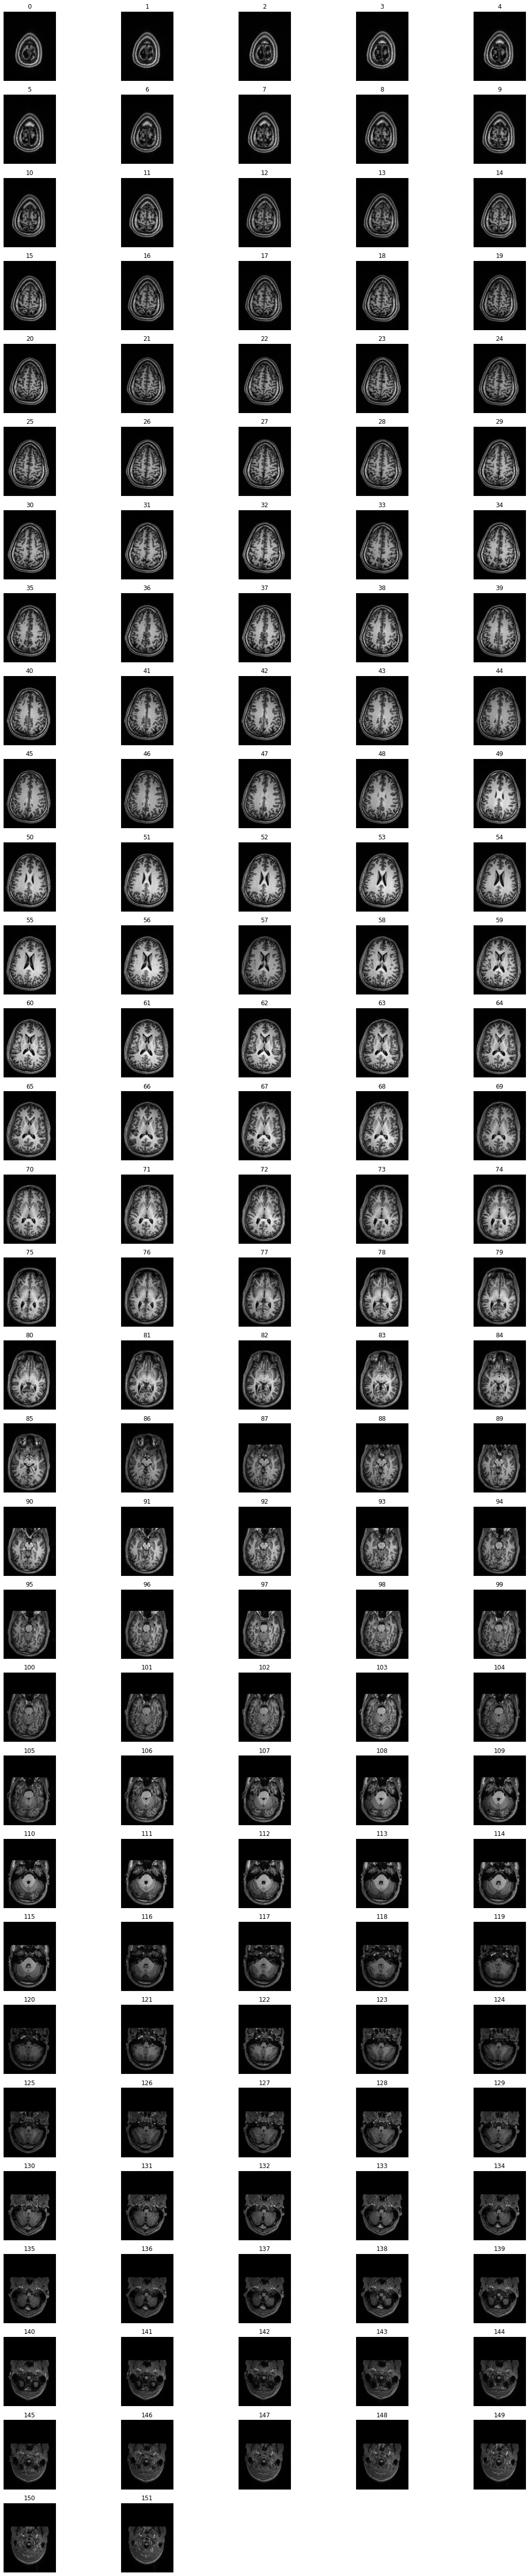

In [ ]:
    import math
    num_rows = math.ceil(len(test_id_skull)/5)
    plt.figure(figsize = (20, 15*num_rows))
    for i, key in enumerate(test_id_skull): # iterates through the dictionary, while the enumerate function keeps track of the index with i
        plt.subplot(5*num_rows,5,i+1)    # the number of images in the grid 
        value = key
        img = value[:,:,0]
        plt.imshow(img, cmap= 'gray')
        plt.axis('off')
        plt.title(i)
    plt.show()

In [ ]:
TRAIN_DATA_PATH = DATA_PATH

X_train, Y_train = create_numpy_array(train_ids, TRAIN_DATA_PATH)
X_val, Y_val = create_numpy_array(val_ids, TRAIN_DATA_PATH)
X_test, Y_test = create_numpy_array(test_ids, TRAIN_DATA_PATH)
# Lets create tensor datasets from numpy arrays
dataset_train = tf.data.Dataset.from_tensor_slices((X_train, Y_train))
dataset_train = dataset_train.map(lambda x, y: {'image': x, 'segmentation_mask': y})
dataset_val = tf.data.Dataset.from_tensor_slices((X_val, Y_val))
dataset_val = dataset_val.map(lambda x, y: {'image': x, 'segmentation_mask': y})
dataset_test = tf.data.Dataset.from_tensor_slices((X_test, Y_test))
dataset_test = dataset_test.map(lambda x, y: {'image': x, 'segmentation_mask': y})

In [ ]:
print(X_train.shape)
print(Y_train.shape)

(12160, 256, 192, 1)
(12160, 256, 192, 1)


In [ ]:
plt.figure(figsize=(10,20))
plt.subplot(1,2,1)
plt.imshow(X_train[12][:,128,:], cmap = 'gray')
plt.axis('off')
plt.title('t2', fontsize=20)
plt.subplot(1,2,2)
plt.imshow(Y_train[12][:,128,:], cmap = 'gray')
plt.axis('off')
plt.title('mask', fontsize=20)

In [ ]:
# Let's create image loader to resize the image
def load_image(datapoint):
    input_image = tf.image.resize(datapoint['image'], (128, 128))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

    return input_image, input_mask

In [ ]:
TRAIN_LENGTH = len(train_ids)
BATCH_SIZE = 40
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = 10

In [ ]:
# Resize the image using load_image function defined earlier
train_images = dataset_train.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
val_images = dataset_val.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
test_images = dataset_test.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
for element in test_images:
  print(element)

In [ ]:
class Augment(tf.keras.layers.Layer):
    def __init__(self, seed=42):
      super().__init__()
      # both use the same seed, so they'll make the same random changes.
      self.augment_inputs = preprocessing.RandomFlip(mode="horizontal_and_vertical", seed=seed)
      self.augment_labels = preprocessing.RandomFlip(mode="horizontal_and_vertical", seed=seed)

    def call(self, inputs, labels):
      inputs = self.augment_inputs(inputs)
      labels = self.augment_labels(labels)
      return inputs, labels

In [ ]:
# Build the input pipeline, applying the Augmentation after batching the inputs.
train_batches = (
    train_images
    .cache()
    .shuffle(BUFFER_SIZE)
    .batch(BATCH_SIZE)
    .repeat()
    .map(Augment())
    .prefetch(buffer_size=tf.data.AUTOTUNE))

val_batches = val_images.batch(BATCH_SIZE)
test_batches = test_images.batch(BATCH_SIZE)

In [ ]:
# Let's train the model now
smooth = 1.
EPOCHS = 40
VAL_SUBSPLITS = 5
VALIDATION_STEPS = 20

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=val_batches)
      

Epoch 1/40
10/10 [==============================] - 350s 36s/step - loss: -0.5363 - dice_coef: 0.5363 - val_loss: -0.3409 - val_dice_coef: 0.3409
Epoch 2/40
10/10 [==============================] - 350s 36s/step - loss: -0.7509 - dice_coef: 0.7509 - val_loss: -0.2757 - val_dice_coef: 0.2757
Epoch 3/40
10/10 [==============================] - 349s 36s/step - loss: -0.8358 - dice_coef: 0.8358 - val_loss: -0.1710 - val_dice_coef: 0.1710
Epoch 4/40
10/10 [==============================] - 348s 36s/step - loss: -0.8577 - dice_coef: 0.8577 - val_loss: -0.2090 - val_dice_coef: 0.2090
Epoch 5/40
10/10 [==============================] - 349s 36s/step - loss: -0.8831 - dice_coef: 0.8831 - val_loss: -0.2316 - val_dice_coef: 0.2316
Epoch 6/40
10/10 [==============================] - 349s 36s/step - loss: -0.8973 - dice_coef: 0.8973 - val_loss: -0.2587 - val_dice_coef: 0.2587
Epoch 7/40
10/10 [==============================] - 352s 37s/step - loss: -0.9105 - dice_coef: 0.9105 - val_loss: -0.3247 - 

#Results

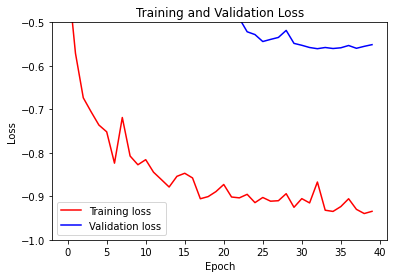

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([-1, -0.5])
plt.legend()
plt.show()

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
      plt.subplot(1, len(display_list), i+1)
      plt.title(title[i])
      plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap = 'gray')
      plt.axis('off')
    plt.show()

In [ ]:
# Let's write a function to show the predictions
def show_predictions(dataset=None, num=1):
    if dataset:
      for image, mask in dataset.take(num):
        pred_mask = model.predict(image)
        display([image[0], mask[0], pred_mask[0]])
    else:
      display([sample_image, sample_mask,
              model.predict(sample_image[tf.newaxis, ...])])
   

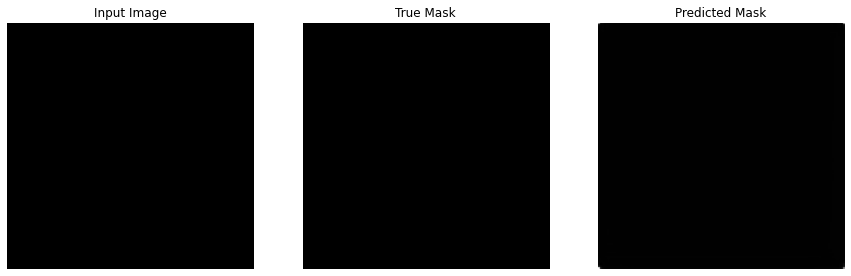

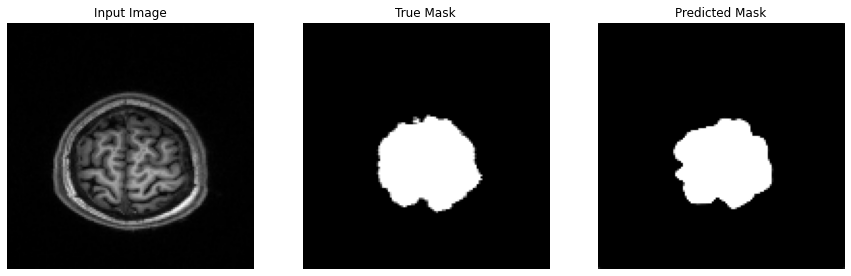

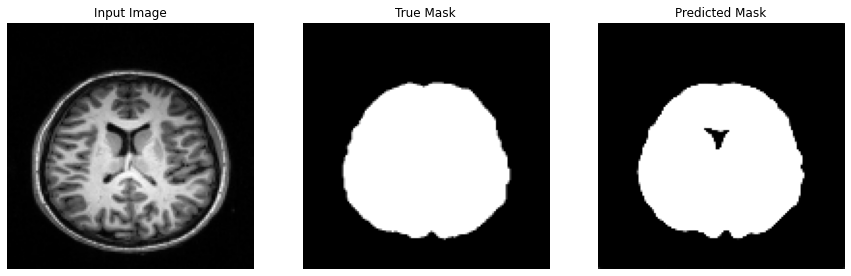

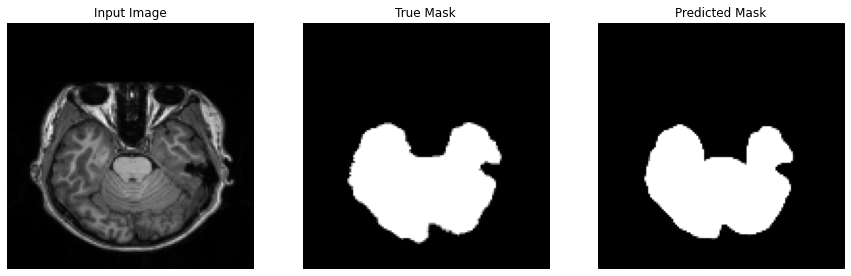

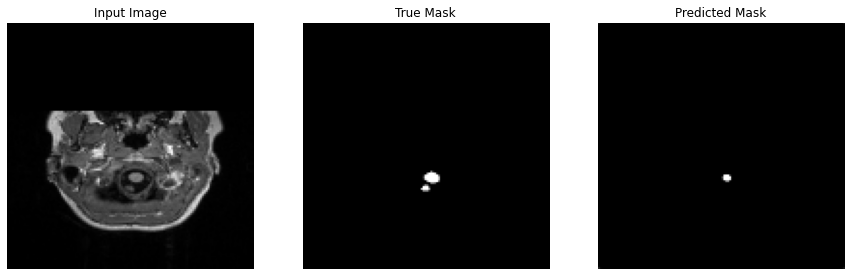

In [ ]:
show_predictions(val_batches, 5)

##Results with some sections

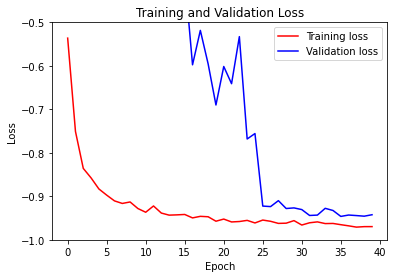

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim([-1, -0.5])
plt.legend()
plt.show()

In [ ]:
# Let's also look at how the dice coef changes (Since the loss function is also derived as 1 - dice_coef, you can skip looking at this)
dice = model_history.history['dice_coef']
val_dice = model_history.history['val_dice_coef']

plt.figure()
plt.plot(model_history.epoch, dice, 'r', label='Training dice')
plt.plot(model_history.epoch, val_dice,'b', label='Validation dice')
plt.title('Training and Validation Dice')
plt.xlabel('Epoch')
plt.ylabel('Dice Value')
plt.ylim([0, 2])
plt.legend()
plt.show()

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
      plt.subplot(1, len(display_list), i+1)
      plt.title(title[i])
      plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]), cmap = 'gray')
      plt.axis('off')
    plt.show()

In [ ]:
# Let's write a function to show the predictions
def show_predictions(dataset=None, num=1):
    if dataset:
      for image, mask in dataset.take(num):
        pred_mask = model.predict(image)
        display([image[0], mask[0], pred_mask[0]])
    else:
      display([sample_image, sample_mask,
              model.predict(sample_image[tf.newaxis, ...])])
   

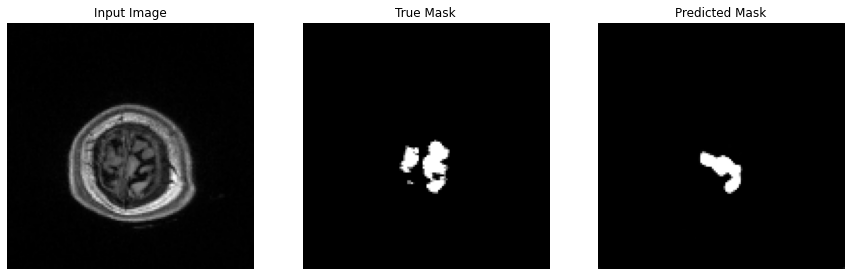

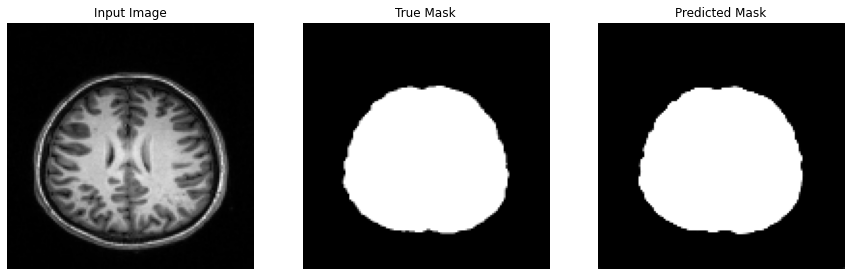

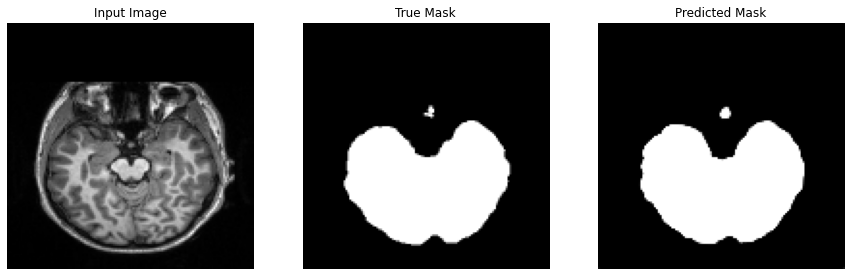

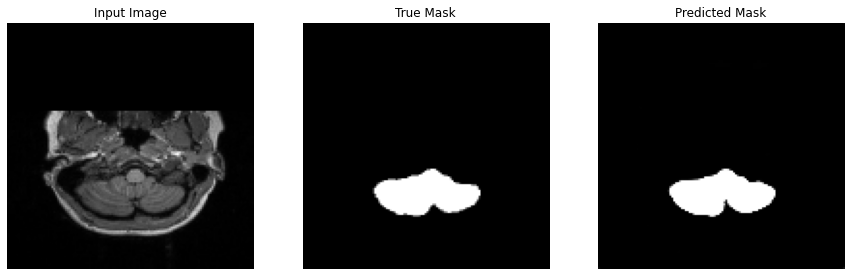

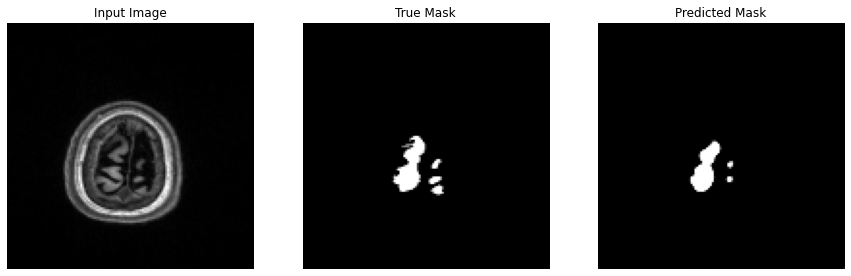

In [ ]:
show_predictions(val_batches, 5)